In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
builder = tfds.builder("tf_flowers")
builder.download_and_prepare()
print(builder.info)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [5]:
ds_all_supervised = builder.as_dataset(as_supervised=True)
assert isinstance(ds_all_supervised, dict)
print(ds_all_supervised.keys())  # ==> ['test', 'train', 'unsupervised']


dict_keys(['train'])


In [6]:
(raw_train, raw_validation, raw_test) = builder.as_dataset(split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True)

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


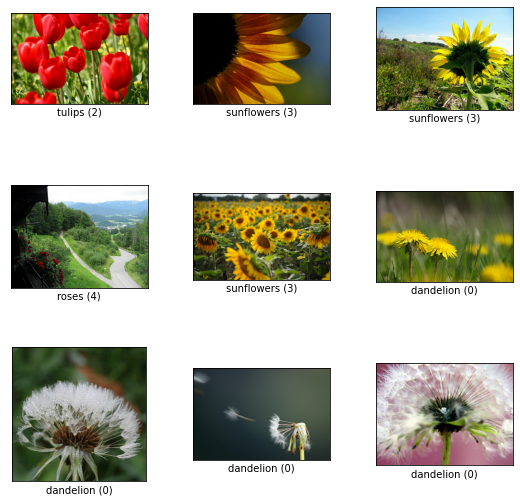

In [8]:
train_data = builder.as_dataset(split="train")
fig = tfds.show_examples(train_data, builder.info)

Show the first two images and labels from the training set:

In [9]:
IMG_SIZE = 100 # Todas las imágenes van a reescalarse a 100x100

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image = image / 255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [10]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [11]:
num_classes = builder.info.features['label'].num_classes # 5 Clases

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
# Nuestro feature map de entrada es 100x100x3: 100x100 píxeles y 3 por los canales RGB
img_input = layers.Input(shape=(100, 100, 3))
# Construye tu red neuronal aquí!! La topología es la misma que hemos usado para Cats & Dogs

# La primera convolución extrae 16 filtros de 3x3, relu va diréctamente embebido en esta capa
# La convolución va seguida, en este caso, de una capa de max-pooling con ventanas de 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# La segunda convolución extrae 32 filtros de 3x3
# Utilizaremos a continuación una capa MaxPooling2D con tamaño de ventana 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# La tercera convolución extraer 64 filtros de tamaño 3x3 y va seguida de otra MaxPooling2D de 2x2.
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Aplana el feature map a un tensor de 1 dimensión para añadir nuestras capas fully connected
x = layers.Flatten()(x)

# Capa fully-connected con función de activación ReLU y 512 neuronas
x = layers.Dense(512, activation='relu')(x)

# Incluimos una capa de dropout
x = layers.Dropout(0.50)(x)

# Capa de salida con un sólo nodo y función de activación sigmoide
output = layers.Dense(num_classes, activation='softmax')(x)


In [12]:
# Configura y compila el modelo
model = Model(img_input, output)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

In [14]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
# Entrenamos el modelo
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches)

Epoch 1/30
23/23 [==============================] - 38s 254ms/step - loss: 1.7155 - acc: 0.3188 - val_loss: 1.4024 - val_acc: 0.3542
Epoch 2/30
23/23 [==============================] - 4s 127ms/step - loss: 1.3139 - acc: 0.4458 - val_loss: 1.2442 - val_acc: 0.4768
Epoch 3/30
23/23 [==============================] - 4s 128ms/step - loss: 1.2092 - acc: 0.5058 - val_loss: 1.2738 - val_acc: 0.4441
Epoch 4/30
23/23 [==============================] - 4s 127ms/step - loss: 1.0838 - acc: 0.5691 - val_loss: 1.1707 - val_acc: 0.5559
Epoch 5/30
23/23 [==============================] - 4s 127ms/step - loss: 1.0139 - acc: 0.6008 - val_loss: 0.9919 - val_acc: 0.6267
Epoch 6/30
23/23 [==============================] - 4s 128ms/step - loss: 0.9439 - acc: 0.6390 - val_loss: 0.9683 - val_acc: 0.6458
Epoch 7/30
23/23 [==============================] - 4s 129ms/step - loss: 0.9069 - acc: 0.6441 - val_loss: 0.9153 - val_acc: 0.6621
Epoch 8/30
23/23 [==============================] - 4s 130ms/step - loss: 0

In [16]:
# Podemos extraer los valores de accuracy y loss del histórico que se ha guardado al entrenar la red
def print_result(my_history):

    acc = my_history.history['acc']
    val_acc = my_history.history['val_acc']

    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']

    # Extraemos el número de épocas
    epochs = range(len(acc))

    # Representamos con plot nuestro accuracy por epoch
    plt.plot(epochs, acc, label = 'train_acc')
    plt.plot(epochs, val_acc, label = 'val_acc')
    title= 'Training and validation accuracy'
    plt.title(title)
    
    plt.legend()
    plt.figure()
    plt.show()

    # Representamos con plot nuestro loss por epoch
    plt.plot(epochs, loss, label = 'loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    title= 'Training and validation loss'
    plt.title(title)
    plt.figure()
    plt.show()
    

    return None

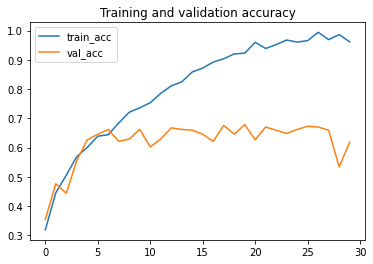

<Figure size 432x288 with 0 Axes>

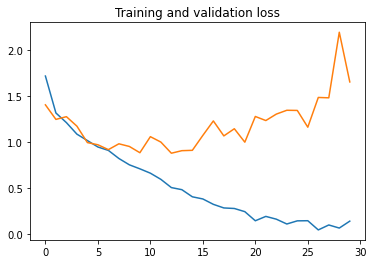

<Figure size 432x288 with 0 Axes>

In [17]:
print_result(history)

### **[TODO] MEJORA EL MODELO USANDO INCEPTION V3**

In [18]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-11-04 17:18:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   193MB/s    in 0.4s    

2021-11-04 17:18:25 (193 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(100, 100, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [20]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [21]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 4, 768)


In [22]:
from tensorflow.keras.optimizers import RMSprop

# Capa flatten para vectorizar nuestro feature map
x = layers.Flatten()(last_output)
# Añadimos una fully connected con 1024 neuronas y función de activación ReLU.
x = layers.Dense(1024, activation='relu')(x)
# Añadimos un Dropout del 0.2
x = layers.Dropout(0.2)(x)
# Añadimos nuestra capa de salida
x = layers.Dense(num_classes, activation='softmax')(x)

# Configuramos y compilamos el modelo
model_incep = Model(pre_trained_model.input, x)
model_incep.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [23]:
#Utilizamos esta función para hacer DataAugmentation de forma similar a ImageDataGenerator

def augmentation_example(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.adjust_saturation(image, 3)
  image = tf.image.adjust_brightness(image, 0.4)
  image = tf.image.rot90(image)
  return image, label

In [24]:
train = raw_train.map(format_example)
#Solo hacemos augmentation al train
train = train.map(augmentation_example)
# train = train.map(py_augment).unbatch()
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [25]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [26]:
# Entrenamos el modelo
history_incep = model_incep.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches)

Epoch 1/30
12/12 [==============================] - 13s 588ms/step - loss: 1.2429 - acc: 0.5657 - val_loss: 0.7051 - val_acc: 0.7711
Epoch 2/30
12/12 [==============================] - 5s 329ms/step - loss: 0.5346 - acc: 0.8123 - val_loss: 0.6297 - val_acc: 0.7847
Epoch 3/30
12/12 [==============================] - 5s 331ms/step - loss: 0.3932 - acc: 0.8750 - val_loss: 0.7803 - val_acc: 0.7057
Epoch 4/30
12/12 [==============================] - 5s 335ms/step - loss: 0.2772 - acc: 0.9149 - val_loss: 0.5810 - val_acc: 0.7875
Epoch 5/30
12/12 [==============================] - 5s 333ms/step - loss: 0.2596 - acc: 0.9227 - val_loss: 0.5550 - val_acc: 0.7956
Epoch 6/30
12/12 [==============================] - 5s 331ms/step - loss: 0.1576 - acc: 0.9639 - val_loss: 0.7147 - val_acc: 0.7357
Epoch 7/30
12/12 [==============================] - 5s 334ms/step - loss: 0.1548 - acc: 0.9612 - val_loss: 0.5911 - val_acc: 0.7929
Epoch 8/30
12/12 [==============================] - 5s 330ms/step - loss: 0

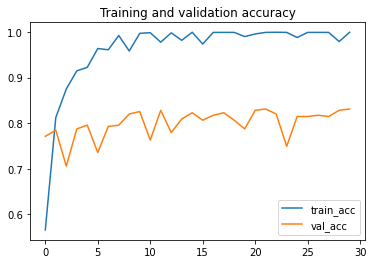

<Figure size 432x288 with 0 Axes>

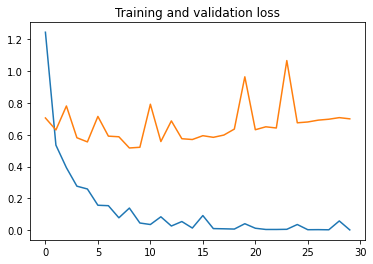

<Figure size 432x288 with 0 Axes>

In [27]:
print_result(history_incep)

In [28]:
unfreeze = False
# Descongelamos todas las capas posteriores a "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

model_incep.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [29]:
# Entrenamos de nuevo el modelo con el fine-tunning realizado
history_incep_fine = model_incep.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches)

Epoch 1/30
12/12 [==============================] - 12s 500ms/step - loss: 0.1607 - acc: 0.9639 - val_loss: 1.0839 - val_acc: 0.7875
Epoch 2/30
12/12 [==============================] - 5s 371ms/step - loss: 0.0374 - acc: 0.9993 - val_loss: 0.9710 - val_acc: 0.8065
Epoch 3/30
12/12 [==============================] - 5s 368ms/step - loss: 0.0180 - acc: 0.9997 - val_loss: 0.9075 - val_acc: 0.8065
Epoch 4/30
12/12 [==============================] - 5s 370ms/step - loss: 0.0102 - acc: 0.9997 - val_loss: 0.8801 - val_acc: 0.8120
Epoch 5/30
12/12 [==============================] - 5s 371ms/step - loss: 0.0058 - acc: 0.9997 - val_loss: 0.8171 - val_acc: 0.8174
Epoch 6/30
12/12 [==============================] - 5s 372ms/step - loss: 0.0041 - acc: 0.9997 - val_loss: 0.8227 - val_acc: 0.8120
Epoch 7/30
12/12 [==============================] - 6s 393ms/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.8075 - val_acc: 0.8229
Epoch 8/30
12/12 [==============================] - 5s 389ms/step - loss: 0

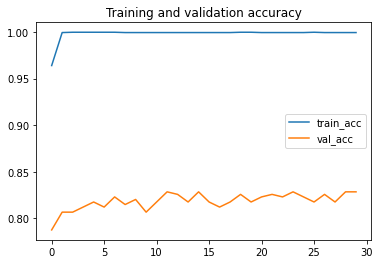

<Figure size 432x288 with 0 Axes>

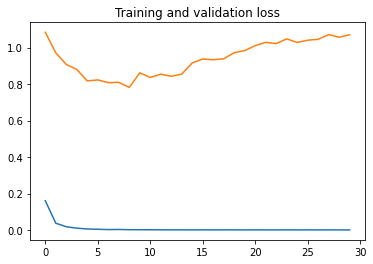

<Figure size 432x288 with 0 Axes>

In [30]:
print_result(history_incep_fine)